In [1]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client, progress
client = Client(n_workers = 9, threads_per_worker=4, memory_limit='80GB')
client

Client Scheduler: tcp://127.0.0.1:49817 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 9 Cores: 36 Memory: 77.31 GB


In [2]:
import noaa_coops as nc
import xarray as xr
import pandas as pd
from netCDF4 import Dataset

In [3]:
charleston = nc.Station(8665530)
print(charleston.lat_lon['lat'], ',', charleston.lat_lon['lon'])

32.780833 , -79.923611


In [4]:
#Hourly water level predictions
#df_water_levels = charleston.get_data(begin_date="20200526", 
                                      #end_date="20210526", 
                                      #product= "predictions",
                                      #datum = "MHHW", 
                                      #interval = "h", 
                                      #units = "english", 
                                      #time_zone="gmt")
#w = df_water_levels.drop(columns=['sigma','flags','QC'])
#df_water_levels

In [5]:
pred_water_level = charleston.get_data(begin_date="20000526", 
                                      end_date="20210526", 
                                      product= "predictions",
                                      datum = "MHHW", 
                                      interval = "h", 
                                      units = "english", 
                                      time_zone="gmt")
pred_water_level

,predicted_wl
date_time,
2000-05-26 00:00:00,-4.712
2000-05-26 01:00:00,-4.294
2000-05-26 02:00:00,-3.472
2000-05-26 03:00:00,-2.463
2000-05-26 04:00:00,-1.563
...,...
2021-05-26 19:00:00,-6.567
2021-05-26 20:00:00,-5.579
2021-05-26 21:00:00,-3.832


In [6]:
Pred_values = pred_water_level['predicted_wl'].values

In [7]:
obs_water_levels = charleston.get_data(begin_date="20000526", 
                                      end_date="20210526", 
                                      product= "water_level",
                                      datum = "MHHW", 
                                      interval = "h", 
                                      units = "english", 
                                      time_zone="gmt")
w = obs_water_levels.drop(columns=['sigma','flags','QC'])

print(w)

                     water_level
date_time                       
2000-05-26 00:00:00       -4.685
2000-05-26 01:00:00       -4.301
2000-05-26 02:00:00       -3.284
2000-05-26 03:00:00       -2.510
2000-05-26 04:00:00       -1.607
...                          ...
2021-05-26 19:00:00       -6.565
2021-05-26 20:00:00       -5.489
2021-05-26 21:00:00       -3.576
2021-05-26 22:00:00       -1.591
2021-05-26 23:00:00       -0.088

[184104 rows x 1 columns]


In [8]:
NTR = w.sub(pred_water_level, fill_value = 0)
NTR

,predicted_wl,water_level
date_time,,
2000-05-26 00:00:00,4.712,-4.685
2000-05-26 01:00:00,4.294,-4.301
2000-05-26 02:00:00,3.472,-3.284
2000-05-26 03:00:00,2.463,-2.510
2000-05-26 04:00:00,1.563,-1.607
...,...,...
2021-05-26 19:00:00,6.567,-6.565
2021-05-26 20:00:00,5.579,-5.489
2021-05-26 21:00:00,3.832,-3.576


In [9]:
neg = -NTR["predicted_wl"]
neg

date_time
2000-05-26 00:00:00   -4.712
2000-05-26 01:00:00   -4.294
2000-05-26 02:00:00   -3.472
2000-05-26 03:00:00   -2.463
2000-05-26 04:00:00   -1.563
                       ...  
2021-05-26 19:00:00   -6.567
2021-05-26 20:00:00   -5.579
2021-05-26 21:00:00   -3.832
2021-05-26 22:00:00   -1.872
2021-05-26 23:00:00   -0.229
Name: predicted_wl, Length: 190032, dtype: float64

In [10]:
ntr = NTR["water_level"] - neg
ntr

date_time
2000-05-26 00:00:00    0.027
2000-05-26 01:00:00   -0.007
2000-05-26 02:00:00    0.188
2000-05-26 03:00:00   -0.047
2000-05-26 04:00:00   -0.044
                       ...  
2021-05-26 19:00:00    0.002
2021-05-26 20:00:00    0.090
2021-05-26 21:00:00    0.256
2021-05-26 22:00:00    0.281
2021-05-26 23:00:00    0.141
Length: 190032, dtype: float64

In [11]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'NTR')

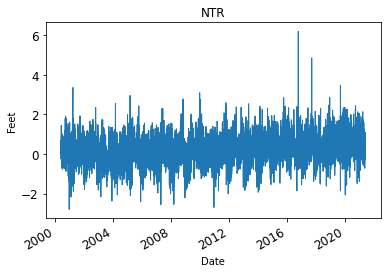

In [12]:
ax = ntr.plot(linewidth=1, fontsize=12);
plt.ylabel('Feet')
plt.xlabel('Date')
plt.title('NTR')

In [13]:
max_value = ntr.max()
min_value = ntr.min()
print(max_value)
print(min_value)

6.2010000000000005
-2.7980000000000005


In [14]:
ntr.idxmax()

Timestamp('2016-10-08 10:00:00')

In [15]:
ntr.idxmin()

Timestamp('2000-12-17 20:00:00')

Text(0.5, 1.0, 'NTR')

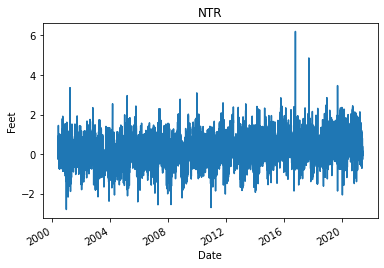

In [16]:
import numpy.polynomial.polynomial as poly
date = ntr.loc['2000-05-26':'2021-05-26']
date.plot()
plt.ylabel('Feet')
plt.xlabel('Date')
plt.title('NTR')

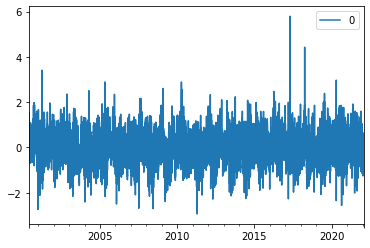

In [17]:
#detrend
y = date.fillna(0.0)
x = pd.Series(range(1,len(y)+1))
len(y),len(x)
coefs = poly.polyfit(x, y, 1)
ffit = poly.polyval(x, coefs)
#plt.plot(x, y)
#plt.plot(x, ffit)

detrendNTR = ntr.values - ffit.values

plot_detrend = pd.DataFrame(detrendNTR,
                           index = pd.date_range('2000-05-26', periods = len(ntr), freq = 'H'))
plot_detrend.plot()

In [18]:
#hourly average
ntr.mean(axis=0)


0.2325046097499352

In [60]:
#NTR monthly average
monthly = ntr.groupby(pd.Grouper(freq='M')).mean()
monthlyAvg = pd.DataFrame(data = monthly)
monthlyAvg


,0
date_time,
2000-05-31,0.584285
2000-06-30,0.029070
2000-07-31,0.315883
2000-08-31,0.269126
2000-09-30,0.342489
...,...
2021-01-31,0.571204
2021-02-28,0.708141
2021-03-31,0.611819


In [61]:
monthlyAvg.mean()

0    0.23384
dtype: float64

In [62]:
#weekly average
#weekly = ntr.groupby(pd.Grouper(freq='W')).mean()
#weekly
#weeklyAvg = pd.DataFrame(data = weekly)
#weeklyAvg

In [28]:
#weeklyAvg.mean()

0    0.231772
dtype: float64

In [63]:
import datetime as dt
from netCDF4 import Dataset, num2date
from mpl_toolkits.basemap import Basemap


In [64]:
#open file
file = Dataset('wspd.mon.mean.nc')

NetCDF Global Attributes:
	title: 'monthly mean wind speed from 4-times daily u and v from the NCEP Reanalysis'
	description: 'Data from NCEP initialized reanalysis (4x/day).  These are interpolated to pressure surfaces from model (sigma) surfaces'
	platform: 'Model'
	Conventions: 'COARDS'
	NCO: '20121012'
	history: 'Mon Jul  5 23:05:54 1999: ncrcat wspd.mon.mean.nc /Datasets/ncep.reanalysis.derived/pressure/wspd.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/wspd.mon.mean.nc\nMade by Cathy Smith 04/12/99 \n(netCDF2.3)\nConverted to chunked, deflated non-packed NetCDF4 2014/09'
	dataset_title: 'NCEP-NCAR Reanalysis 1'
	References: 'http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html'
NetCDF dimension information:
	Name: level
		size: 17
		type: dtype('float32')
		units: 'millibar'
		long_name: 'Level'
		positive: 'down'
		GRIB_id: 100
		GRIB_name: 'hPa'
		actual_range: array([1000.,   10.], dtype=float32)
		axis: 'Z'
	Name: lat
		size: 73
		type: dtype('float32')

In [65]:
#load variables
wspd = file.variables['wspd'][:]
time = file.variables['time']
lon = file.variables['lon'][:]
lat = file.variables['lat'][:]

In [66]:
import xarray as xr
ds = xr.open_dataset('wspd.mon.mean.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 881)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-05-01
Data variables:
    wspd     (time, level, lat, lon) float32 ...
Attributes:
    title:          monthly mean wind speed from 4-times daily u and v from t...
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Mon Jul  5 23:05:54 1999: ncrcat wspd.mon.mean.nc /Datase...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [67]:
wspd = ds.variables['wspd'][:]
time = ds.variables['time']
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
#create 2D lat and lon
import numpy as np
lon, lat = np.meshgrid(lon, lat)

In [68]:
from netCDF4 import Dataset, num2date

In [69]:
df = ds['wspd'].to_dataframe()
df
#drop levels other than time (lat, lon, and level)
new = df.droplevel(level = 2) #drops latitude level
New = new.droplevel(level = 1) #drops lon
wspd_df = New.droplevel(level=1) #drops level
wspd_df

,wspd
time,
1948-01-01,4.770004
1948-01-01,4.770004
1948-01-01,4.779999
1948-01-01,4.770004
1948-01-01,4.770004
...,...
2021-05-01,14.747640
2021-05-01,14.743247
2021-05-01,14.747523


In [73]:
#monthly averages for each level
monthly = wspd_df.groupby(pd.Grouper(freq='M')).mean()
wspdMonthlyAvg = pd.DataFrame(data = monthly)
#select same time range as NTR (253)
wspdRange = wspdMonthlyAvg.tail(253)


In [75]:
#convert wspd to xarray
wspdxr = wspdRange.to_xarray()
wspdxr

<xarray.Dataset>
Dimensions:  (time: 253)
Coordinates:
  * time     (time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31
Data variables:
    wspd     (time) float32 13.43 13.92 14.66 14.71 ... 13.91 13.86 13.97 13.77

In [76]:
#convert ntr to xarray
ntrxr = monthlyAvg.to_xarray()
ntrxr

<xarray.Dataset>
Dimensions:    (date_time: 253)
Coordinates:
  * date_time  (date_time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31
Data variables:
    0          (date_time) float64 0.5843 0.02907 0.3159 ... 0.4672 0.3988

In [78]:
#merge two xarray
new = xr.merge([wspdxr, ntrxr])
new

<xarray.Dataset>
Dimensions:    (date_time: 253, time: 253)
Coordinates:
  * time       (time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31
  * date_time  (date_time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31
Data variables:
    wspd       (time) float32 13.43 13.92 14.66 14.71 ... 13.86 13.97 13.77
    0          (date_time) float64 0.5843 0.02907 0.3159 ... 0.4672 0.3988

In [79]:
#rename variable 0 to  ntr
name_dict = {0:'ntr'}
new = new.rename_vars(name_dict)
new

<xarray.Dataset>
Dimensions:    (date_time: 253, time: 253)
Coordinates:
  * time       (time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31
  * date_time  (date_time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31
Data variables:
    wspd       (time) float32 13.43 13.92 14.66 14.71 ... 13.86 13.97 13.77
    ntr        (date_time) float64 0.5843 0.02907 0.3159 ... 0.4672 0.3988

In [82]:
#convert back to df to compute correlation between the two columns
combinedDF= new.to_dataframe()
combinedDF
#get rid of date_time level so there is only one time index since they were both the same
DF= combinedDF.droplevel(level = 0)
DF

,wspd,ntr
time,,
2000-05-31,13.432533,0.584285
2000-06-30,13.920701,0.584285
2000-07-31,14.661649,0.584285
2000-08-31,14.706227,0.584285
2000-09-30,14.586670,0.584285
...,...,...
2021-01-31,14.018969,0.398782
2021-02-28,13.909124,0.398782
2021-03-31,13.857503,0.398782


In [87]:

#correlation
DF['wspd'].corr(DF['ntr'])

-2.927630062556134e-19

In [89]:
DF.corr()

,wspd,ntr
wspd,1.000000e+00,1.553411e-18
ntr,1.553411e-18,1.000000e+00
